# Advanced Portfolio Optimization & Risk Analytics

This notebook demonstrates a robust workflow for constructing and analyzing investment portfolios using modern quantitative finance techniques. The workflow includes:

1. **Configuration & Data Pipeline**: Parameter setup and data processing using advanced estimation methods.
2. **Interactive Optimization**: Determining optimal portfolio weights to maximize risk-adjusted returns.
3. **Risk & Return Simulation**: Projecting future performance and quantifying risk via Monte Carlo simulation.

All core logic is modularized in the accompanying Python modules, ensuring this notebook remains focused on high-level analysis and results.

## 1. Setup and Configuration

### 1.1. Import Libraries

In [ ]:
%load_ext autoreload
%autoreload 2

import numpy as np
import seaborn as sns
from ipywidgets import FloatSlider, IntSlider, interact

from portfolio_analyzer.analysis.monte_carlo_simulator import (
    MonteCarloSimulator,
    SimulationStatisticsCalculator,
)
from portfolio_analyzer.config.config import AppConfig
from portfolio_analyzer.core.optimizer import PortfolioOptimizer
from portfolio_analyzer.interactive.session import PortfolioAnalysisSession
from portfolio_analyzer.logging_config import setup_logging
from portfolio_analyzer.reporting.plotting import (
    calculate_correlation_matrix,
    plot_correlation_heatmap,
    plot_correlation_network,
    plot_efficient_frontier,
)

setup_logging()

sns.set_theme(style="whitegrid", palette="pastel")
sns.set_context("notebook")

2025-08-01 23:45:17 - root - INFO - Logging configured. Console level: INFO, File level: DEBUG


### 1.2. Define Parameters

All key parameters are managed via the [`AppConfig`](../src/portfolio_analyzer/config.py) class. This centralizes control over tickers, date ranges, and model hyperparameters. User-defined views for the Black-Litterman model can also be specified here.

In [1]:
# --- General Model Configuration ---
config = AppConfig.get_instance()
config.monte_carlo.num_simulations = 1000

## 2. Data Pipeline & Input Preparation

The [`input_preparator`](../src/portfolio_analyzer/data/input_preparator.py) module encapsulates the end-to-end data pipeline: fetching historical prices and market capitalizations, computing log returns, and preparing the mean return vector and covariance matrix for optimization.

**Note:** If enabled, the pipeline automatically performs DCF analysis for each asset to generate forward-looking views for the Black-Litterman model. Assets lacking market capitalization default to their implied equilibrium return, blending market-neutral priors with DCF-based views.

Robust estimation techniques such as EWMA, Ledoit-Wolf shrinkage, and Black-Litterman blending are used to ensure stability and reliability of model inputs.


In [2]:
import yfinance as yf

import portfolio_analyzer.data.input_preparator as newip
from portfolio_analyzer.data.data_fetcher import DataFetcher
from portfolio_analyzer.data.new_models import ModelInputs
from portfolio_analyzer.data.repository import Repository
from portfolio_analyzer.return_estimator import (
    CAPM,
    EWMA,
    BlackLitterman,
    BlendedReturn,
    ConstantReturn,
    FillNaNReturn,
    ReturnEstimator,
)

data_fetcher = DataFetcher(provider=yf)
repository = Repository(data_fetcher=data_fetcher)

ewma_returns: ReturnEstimator = EWMA(
    start_date=config.date_range.start,
    end_date=config.date_range.end,
    tickers=config.tickers,
    repository=repository,
    config=config,
)

capm_returns: ReturnEstimator = CAPM(
    start_date=config.date_range.start,
    end_date=config.date_range.end,
    tickers=config.tickers,
    repository=repository,
    config=config,
)

constant_returns = ConstantReturn(
    constant_return=np.log(config.risk_free_rate + 1),
    config=config,
)

filled_capm_returns: ReturnEstimator = FillNaNReturn(
    returns=capm_returns,
    replacement_returns=constant_returns,
)

blended_returns: ReturnEstimator = BlendedReturn(
    weighted_estimators=[
        (ewma_returns, config.black_litterman.momentum_blend_weight),
        (filled_capm_returns, 1 - config.black_litterman.momentum_blend_weight),
    ],
)

bl_returns: BlackLitterman = BlackLitterman(
    view_vector=blended_returns.get_returns(),
    start_date=config.date_range.start,
    end_date=config.date_range.end,
    tickers=config.tickers,
    config=config,
    repository=repository,
)

model_inputs: ModelInputs = newip.prepare_model_inputs(
    config=config,
    returns=bl_returns,
    repository=repository,
    start_date=config.date_range.start.strftime("%Y-%m-%d"),
    end_date=config.date_range.end.strftime("%Y-%m-%d"),
    tickers=config.tickers,
)

# model_inputs = ip.prepare_model_inputs(config, repository)
mean_returns = model_inputs.returns.expected_returns
cov_matrix = model_inputs.returns.covariance
log_returns = model_inputs.prices.log_returns
close_df = model_inputs.prices.close_prices
final_tickers = model_inputs.universe.tickers

2025-08-01 23:45:20 - portfolio_analyzer.data.data_fetcher - INFO - Fetching historical price data for 21 tickers...
2025-08-01 23:45:31 - portfolio_analyzer.data.data_fetcher - INFO - Fetching historical price data for 1 tickers...
2025-08-01 23:45:41 - portfolio_analyzer.data.data_fetcher - INFO - Fetching market cap data for 21 tickers...
2025-08-01 23:45:41 - portfolio_analyzer.data.data_fetcher - WARNING - Market cap not available for 0P00000B0I. Defaulting to 0.
2025-08-01 23:45:41 - portfolio_analyzer.data.data_fetcher - WARNING - Market cap not available for 0P00000MVB.IR. Defaulting to 0.
2025-08-01 23:45:41 - portfolio_analyzer.data.data_fetcher - WARNING - Market cap not available for 0P0001IMY8.F. Defaulting to 0.
2025-08-01 23:45:44 - portfolio_analyzer.data.input_preparator - INFO - --- Starting Data Pipeline for 21 tickers from 2020-08-02 to 2025-08-01 ---
2025-08-01 23:45:44 - portfolio_analyzer.data.data_fetcher - INFO - Fetching historical price data for 21 tickers...

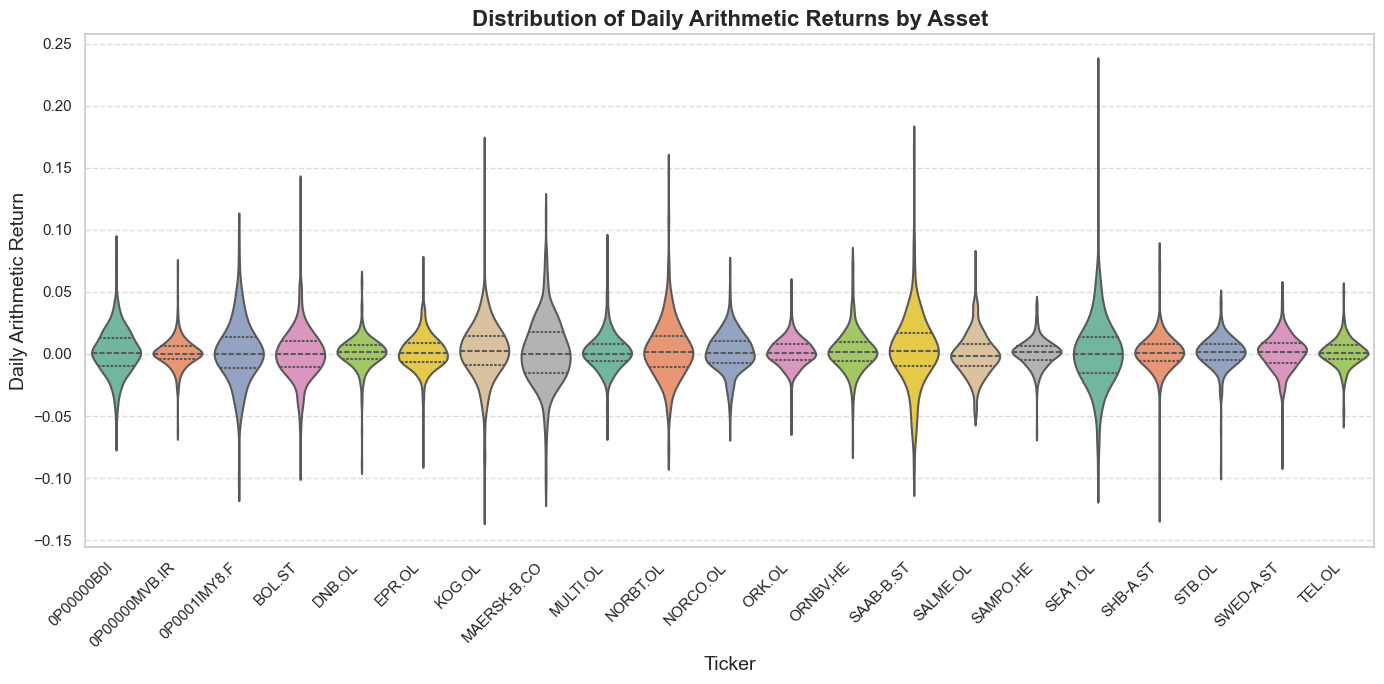

In [3]:
import matplotlib.pyplot as plt

# Visualize the distribution of daily returns for the processed assets
arithmetic_returns = log_returns.apply(lambda x: np.exp(x) - 1)
plt.figure(figsize=(14, 7))
sns.violinplot(data=arithmetic_returns, palette="Set2", inner="quartile", linewidth=1.5)
plt.title("Distribution of Daily Arithmetic Returns by Asset", fontsize=16, fontweight="bold")
plt.xlabel("Ticker", fontsize=14)
plt.ylabel("Daily Arithmetic Return", fontsize=14)
plt.xticks(rotation=45, ha="right", fontsize=11)
plt.yticks(fontsize=11)
plt.grid(True, linestyle="--", alpha=0.7, axis="y")
plt.tight_layout()
plt.show()

### 2.1. Review Model Return Estimates

After running the pipeline, compare the following annualized return estimates for each asset:

- **Historical (EWMA Shrunk):** Backward-looking returns based on historical prices.
- **Implied Equilibrium:** Forward-looking returns implied by market capitalization weights.
- **BL Posterior (Final):** The final blended return from the Black-Litterman model, combining equilibrium returns with DCF-based views. This vector is used for portfolio optimization.

In [4]:
import pandas as pd

returns_df = pd.DataFrame(index=final_tickers)


def log_to_arith(r):
    return np.exp(r) - 1 if r is not None else None


returns_df["EWMA Returns"] = ewma_returns.get_returns().apply(log_to_arith)
returns_df["CAPM Returns"] = filled_capm_returns.get_returns().apply(log_to_arith)
returns_df["Implied Equilibrium Returns"] = bl_returns.get_implied_equilibrium_returns().apply(
    log_to_arith
)
returns_df["Final BL Returns"] = bl_returns.get_returns().apply(log_to_arith)

display(
    returns_df.style.format("{:.2%}")
    .background_gradient(cmap="viridis", axis=0)
    .set_caption("Comparison of Annualized Arithmetic Return Estimates")
    .set_properties(**{"text-align": "right"})
    .highlight_max(axis=0, color="lightgreen")
    .highlight_min(axis=0, color="lightcoral")
)

,EWMA Returns,CAPM Returns,Implied Equilibrium Returns,Final BL Returns
0P00000B0I,29.22%,4.07%,3.23%,10.34%
0P00000MVB.IR,42.72%,4.07%,0.52%,13.43%
0P0001IMY8.F,36.38%,4.07%,2.85%,13.19%
BOL.ST,-10.07%,12.94%,4.45%,5.83%
DNB.OL,-1.26%,8.14%,5.36%,5.85%
EPR.OL,85.76%,8.53%,1.00%,26.35%
KOG.OL,-24.29%,6.36%,10.71%,-2.24%
MAERSK-B.CO,33.64%,12.78%,7.52%,18.32%
MULTI.OL,37.45%,9.99%,1.70%,16.78%
NORBT.OL,98.85%,7.91%,5.33%,29.02%


### Visualizing Asset Correlations

Before optimization, it is essential to understand the relationships between selected assets. The correlation matrix and network graph below help assess diversification potential within the portfolio.


Displaying Clustered Correlation Heatmap:


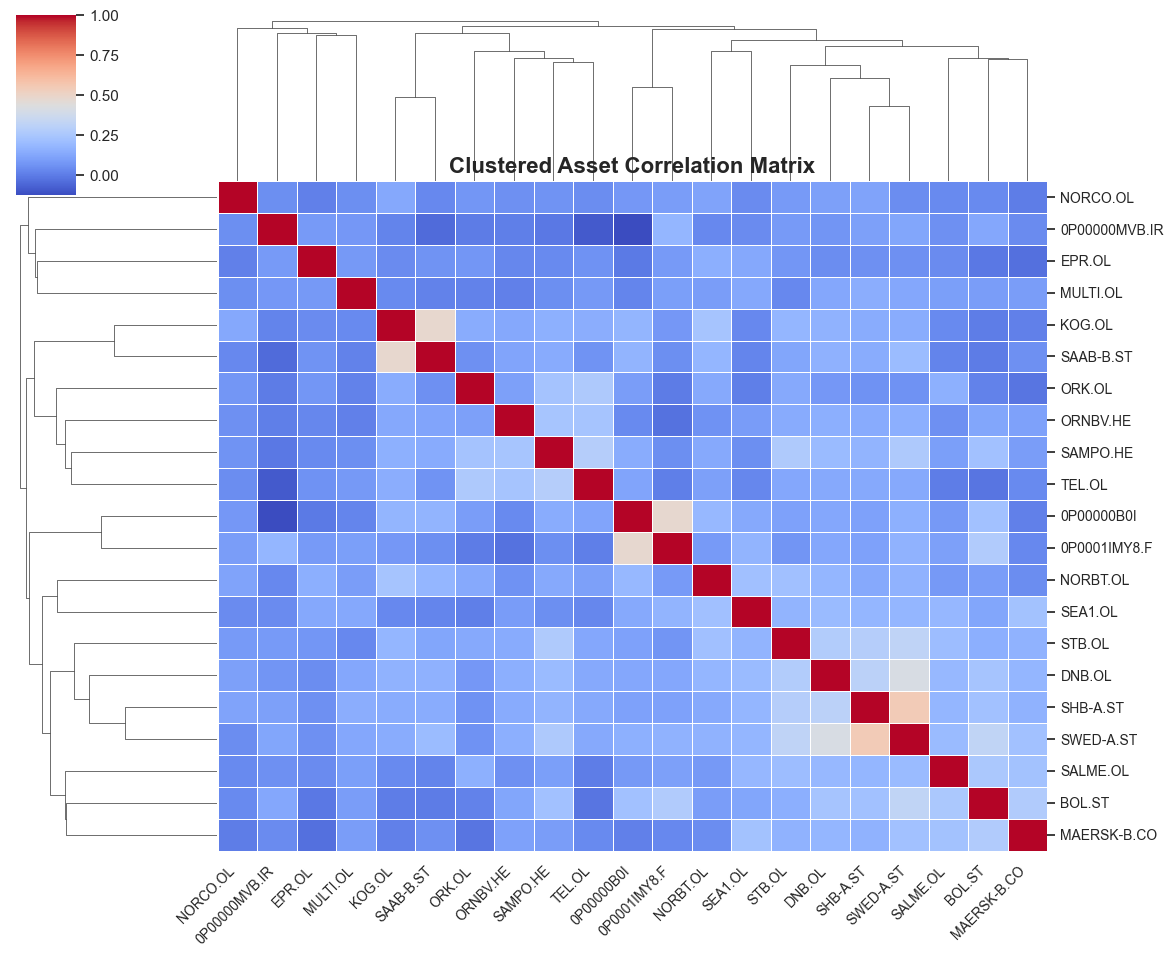


Displaying Correlation Network Graph:


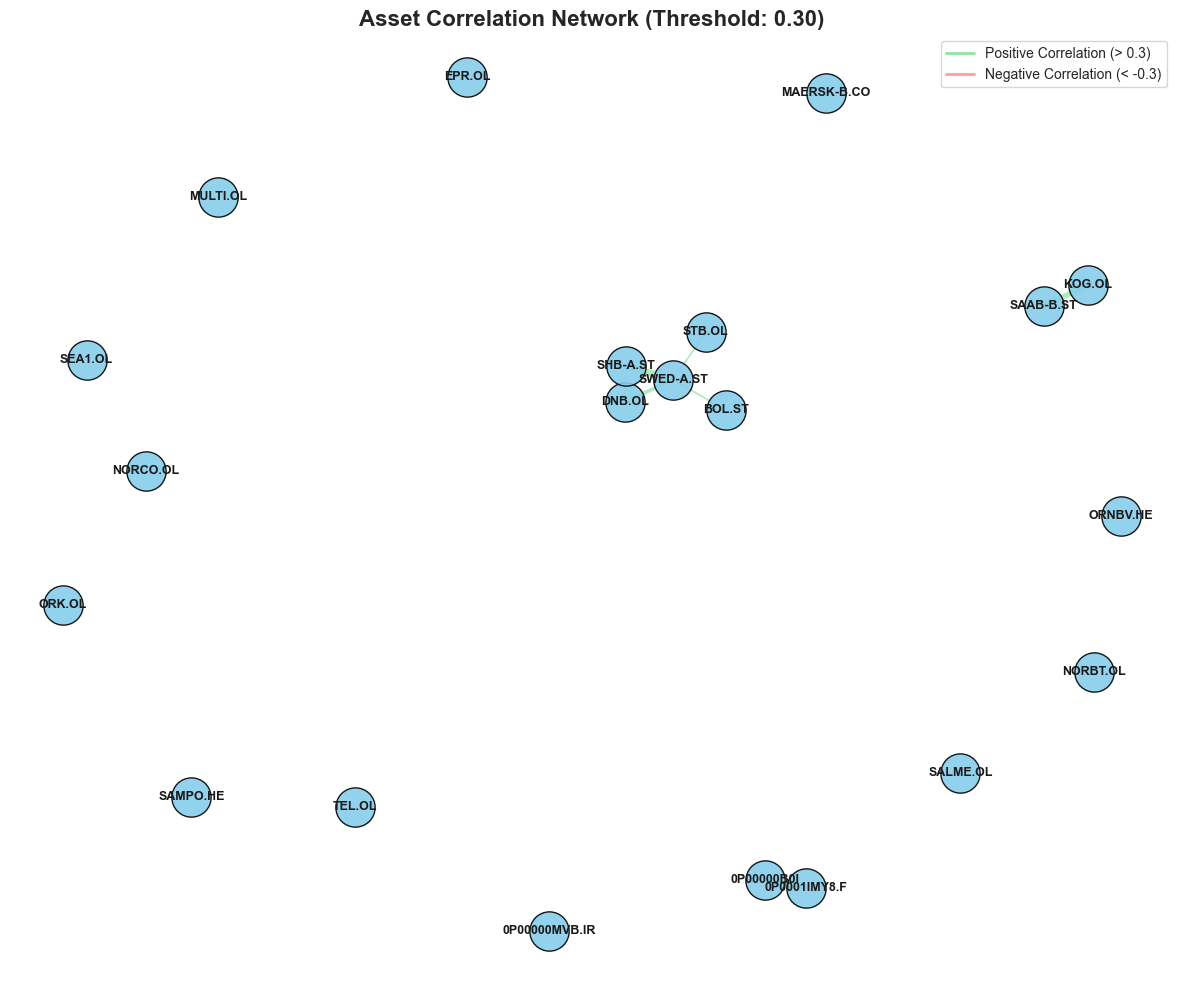

In [5]:
if not cov_matrix.empty:
    correlation_matrix_df = calculate_correlation_matrix(cov_matrix)

    plot_correlation_heatmap(correlation_matrix_df)
    plot_correlation_network(correlation_matrix_df, threshold=0.3)
else:
    print("Covariance matrix is empty. Skipping correlation plots.")

## 3. Interactive Portfolio Optimization

The next step is to determine the optimal portfolio weights by maximizing the Sharpe Ratio, subject to constraints such as maximum allocation per asset. The L2 regularization parameter (`lambda_reg`) can be adjusted interactively to control overfitting and promote diversification.

--- Interactive Portfolio Optimization ---


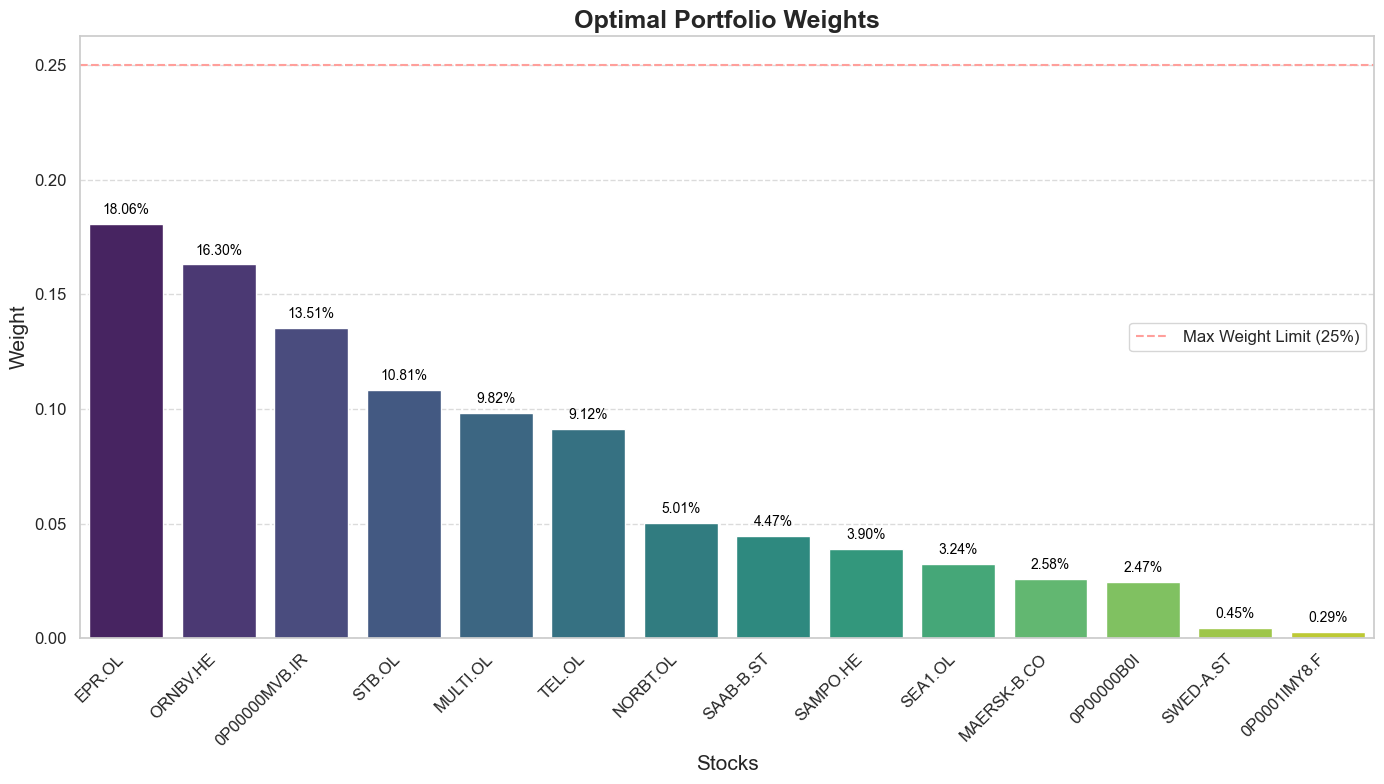

In [6]:
from portfolio_analyzer.core.objectives import NegativeSharpeRatio

optimizer = PortfolioOptimizer(
    mean_returns=model_inputs.returns.expected_returns,
    cov_matrix=model_inputs.returns.covariance,
    config=config,
    objective=NegativeSharpeRatio(
        mean_returns=model_inputs.returns.expected_returns,
        cov_matrix=model_inputs.returns.covariance,
        risk_free_rate=config.risk_free_rate,
        lambda_reg=config.optimization.lambda_reg,
    ),
)

stats_calculator = SimulationStatisticsCalculator(initial_value=config.monte_carlo.initial_value)

mc_simulator = MonteCarloSimulator(config=config, stats_calculator=stats_calculator)

session = PortfolioAnalysisSession(
    config,
    optimizer=optimizer,
    mc_simulator=mc_simulator,
)

print("--- Interactive Portfolio Optimization ---")
session.run_interactive_optimization()

## 4. Monte Carlo Simulation

To assess the potential future performance of the optimized portfolio, we run a Monte Carlo simulation. This projects thousands of possible future portfolio paths, quantifying the range of outcomes and associated risks. Simulation parameters, including the use of a Student’s t-distribution for fat tails, can be adjusted interactively.

In [7]:
print("\n--- Monte Carlo Simulation ---")
interact(
    session.run_interactive_monte_carlo,
    num_sim_interactive=IntSlider(
        min=1000,
        max=100000,
        step=1000,
        value=config.monte_carlo.num_simulations,
        description="Num Simulations:",
        continuous_update=False,
        layout={"width": "500px"},
    ),
    time_horizon_interactive=FloatSlider(
        min=0.5,
        max=10.0,
        step=0.5,
        value=config.monte_carlo.time_horizon_years,
        description="Time Horizon (Yrs):",
        continuous_update=False,
        layout={"width": "500px"},
    ),
    df_t_interactive=IntSlider(
        min=0,
        max=30,
        step=1,
        value=config.monte_carlo.df_t_distribution,
        description="Student-t df (0-2=Normal):",
        continuous_update=False,
        layout={"width": "500px"},
    ),
)


--- Monte Carlo Simulation ---


interactive(children=(IntSlider(value=1000, continuous_update=False, description='Num Simulations:', layout=La…

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

## 5. Efficient Frontier Analysis

The efficient frontier illustrates the set of optimal portfolios offering the highest expected return for a given level of risk. This visualization highlights:

- **Maximum Sharpe Ratio Portfolio:** The tangency portfolio with the best risk-adjusted return.
- **Minimum Volatility Portfolio:** The portfolio with the lowest achievable risk.

Both are key reference points for portfolio construction.


--- Efficient Frontier Analysis ---

Maximum Sharpe Ratio Portfolio:



Minimum Volatility Portfolio:


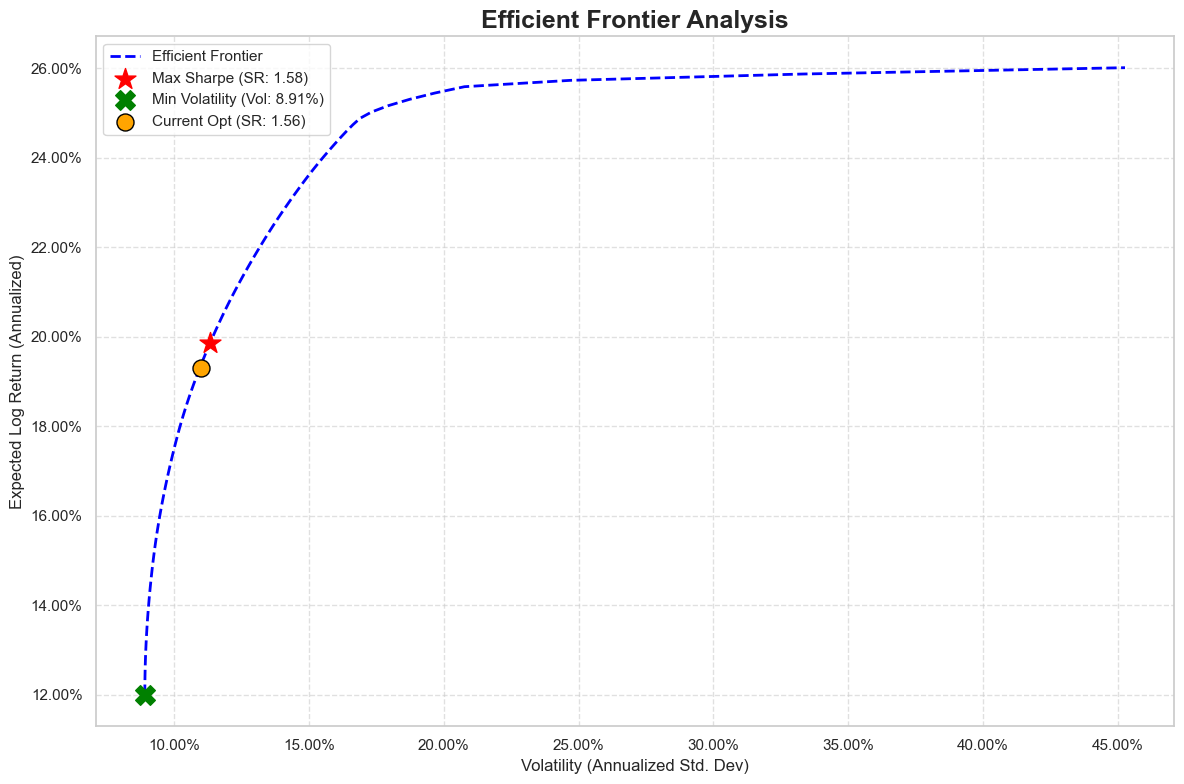

In [8]:
# --- Calculate and Plot the Efficient Frontier ---
from portfolio_analyzer.reporting.display import display_optimization_summary_html


print("\n--- Efficient Frontier Analysis ---")

if "session" in locals() and session.optimizer:
    try:
        from portfolio_analyzer.analysis.frontier import EfficientFrontierAnalyzer

        frontier_analyzer = EfficientFrontierAnalyzer(
            mean_returns=model_inputs.returns.expected_returns,
            cov_matrix=model_inputs.returns.covariance,
            config=config,
        )
        frontier_df, max_sharpe_res, min_vol_res = frontier_analyzer.calculate(num_points=100)

        print("\nMaximum Sharpe Ratio Portfolio:")
        display(display_optimization_summary_html(max_sharpe_res))

        print("\nMinimum Volatility Portfolio:")
        display(display_optimization_summary_html(min_vol_res))

        # Plot the efficient frontier, highlighting the interactively found portfolio
        plot_efficient_frontier(
            frontier_df,
            max_sharpe_res,
            min_vol_res,
            current_opt_result=session.latest_result,
        )
    except Exception as e:
        print(f"Could not generate efficient frontier: {e}")
else:
    print("Analysis session not initialized. Please run the interactive optimization cell first.")

## 6. Strategy Backtesting

Finally, we conduct a historical backtest to evaluate the strategy’s real-world performance. The backtester rebalances the portfolio at a fixed frequency (e.g., quarterly), using a rolling lookback window to update optimization inputs at each step. Results are benchmarked against a relevant market index.

In [9]:
"""# Define a benchmark index to compare against
# ^OSEBX is the Oslo Børs Benchmark Index

BENCHMARK_TICKER = "OSEBX.OL"

# Initialize and run the backtester
backtester = Backtester(config, optimizer_cls=PortfolioOptimizer, repository=repository)
backtest_results, performance_metrics = backtester.run(benchmark_ticker=BENCHMARK_TICKER)

clear_output(wait=True)

if not backtest_results.empty:
    # Display performance metrics using the new reporting function
    display(display_backtest_summary_html(performance_metrics))

    # Plot the results using the new dedicated function
    plot_backtest_results(backtest_results, benchmark_ticker)
    plt.tight_layout()
    plt.show()
else:
    print("Backtest did not produce any results.")"""

'# Define a benchmark index to compare against\n# ^OSEBX is the Oslo Børs Benchmark Index\n\nBENCHMARK_TICKER = "OSEBX.OL"\n\n# Initialize and run the backtester\nbacktester = Backtester(config, optimizer_cls=PortfolioOptimizer, repository=repository)\nbacktest_results, performance_metrics = backtester.run(benchmark_ticker=BENCHMARK_TICKER)\n\nclear_output(wait=True)\n\nif not backtest_results.empty:\n    # Display performance metrics using the new reporting function\n    display(display_backtest_summary_html(performance_metrics))\n\n    # Plot the results using the new dedicated function\n    plot_backtest_results(backtest_results, benchmark_ticker)\n    plt.tight_layout()\n    plt.show()\nelse:\n    print("Backtest did not produce any results.")'